# Example GSE120861

### Dataset
This is an demonstration of analyzing CRISPRi scRNA-seq screen with Normalisr. Only a subset of 30 gRNAs and ~7000 cells are extracted from GSE120861 highmoi dataset for this demonstration. You can change it to the full highmoi dataset or other datasets, by following the guideline in README.

**Warning**: You will only get the actual results with the **full dataset** of all gRNAs and cells. Dropping gRNAs reduces the amount of competition that can be accounted for. By default, this example dataset only contains 30 gRNAs compared to over 3,000 in the 'highmoi' dataset or 13,000 in the 'screen' dataset of GSE120861. This example is intended as a demonstration of use for Normalisr, rather than an exact reproduction of our results in the manuscript.

### Usage
You can get the help of any function by typing ?func in jupyter notebook. For example, the line below shows documentation for function 'open'.

`?open`

To get help for Normalisr, try a specific function such as

`import normalisr as norm
?norm.de.de`

In [1]:
import numpy as np
import normalisr as norm
from os.path import join as pjoin
import matplotlib.pyplot as plt

diri='../data/highmoi'

### Optional extra logging

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

### Load data

In [2]:
dt0=np.loadtxt(pjoin(diri,'0_read.tsv.gz'),delimiter='\t',dtype=int)
dg=np.loadtxt(pjoin(diri,'0_group.tsv.gz'),delimiter='\t',dtype=int)
dc=np.loadtxt(pjoin(diri,'0_cov.tsv.gz'),delimiter='\t',dtype=int)
with open(pjoin(diri,'0_gene.txt'),'r') as f:
	namet=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cell.txt'),'r') as f:
	names=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_gRNA.txt'),'r') as f:
	nameg=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cov.txt'),'r') as f:
	namec=np.array([x.strip() for x in f.readlines()])
nc,ng,ns,nt=[len(x) for x in [namec,nameg,names,namet]]
assert dt0.shape==(nt,ns) and dg.shape==(ng,ns) and dc.shape==(nc,ns)

### Initial QC for low read cell and gene removal

In [3]:
select=norm.qc.qc_reads(dt0,0,50,0.02,500,100,0)
print('Genes passed QC: {}/{}'.format(len(select[0]),nt))
print('Cells passed QC: {}/{}'.format(len(select[1]),ns))

dt0=dt0[select[0]][:,select[1]].copy()
dg=dg[:,select[1]].copy()
dc=dc[:,select[1]].copy()
namet=namet[select[0]]
names=names[select[1]]
ns,nt=[len(x) for x in [names,namet]]
assert dt0.shape==(nt,ns) and dg.shape==(ng,ns) and dc.shape==(nc,ns)

Genes passed QC: 10995/32738
Cells passed QC: 6929/6929


### Compute Bayesian logCPM and cellular summary covariates

In [4]:
dt,_,_,dc2=norm.lcpm.lcpm(dt0)
dc=np.concatenate([dc,dc2],axis=0)

### Normalize covariates and add constant-1 covariate

In [5]:
dc=norm.norm.normcov(dc)

### Compute variance normalization factors for each gene and each cell

In [6]:
sf=norm.lcpm.scaling_factor(dt0)
weight=norm.norm.compute_var(dt,dc)

### Normalize gene expression at mean and variance levels and covariates at variance level

In [7]:
dt,dc=norm.norm.normvar(dt,dc,weight,sf)

### Perform differential expression test with competition-naive and competition-aware methods

In [8]:
methods=['naive','aware']

de_naive=norm.de.de(dg,dt,dc)
de_aware=norm.de.de(dg,dt,dc,single=4)

## Visualization
**Warning**: You will only get the actual method performances with the **full dataset** of all gRNAs and cells. Dropping gRNAs reduces the amount of competition that can be accounted for. By default, this example dataset only contains 30 gRNAs compared to over 3,000 in the 'highmoi' dataset or 13,000 in the 'screen' dataset of GSE120861. This example is intended as a demonstration of use for Normalisr, rather than an exact reproduction of our results in the manuscript.

### Non-targeting-control (NTC) P-value distribution

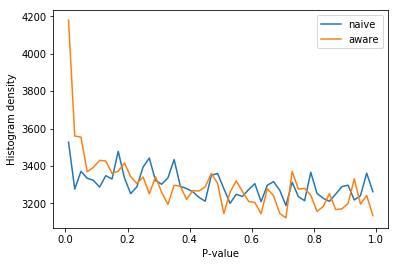

In [9]:
t1=[x.endswith('_negctrl') for x in nameg]
dx=np.linspace(0,1,51)
dy=[np.histogram(x[0][t1],bins=dx)[0] for x in [de_naive,de_aware]]

for xi in range(len(methods)):
	plt.plot((dx[1:]+dx[:-1])/2,dy[xi],label=methods[xi])
plt.xlabel('P-value')
plt.ylabel('Histogram density')
plt.legend();

### LogFC distribution against all genes

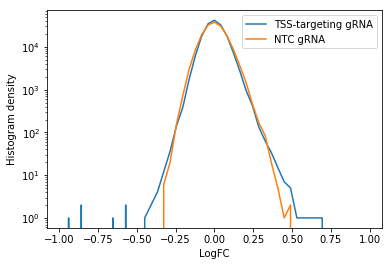

In [10]:
t1=np.array([x.split('_')[1]=='TSS' for x in nameg])
dx=np.linspace(-1,1,50)
dy=[np.histogram(de_aware[1][x],bins=dx)[0] for x in [t1,~t1]]

plt.semilogy((dx[1:]+dx[:-1])/2,dy[0],label='TSS-targeting gRNA');
plt.semilogy((dx[1:]+dx[:-1])/2,dy[1],label='NTC gRNA');
plt.xlabel('LogFC')
plt.ylabel('Histogram density')
plt.legend();